# Cycle GAN model for Image Style Transfer (Image to Image Translations)

Using summer2winter_yosemite dataset (you can find it as summer2winter_yosemite.zip)

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Preprocessor:
    def __init__(self, image_class, train_dir, test_dir, image_size, batch_size):
        '''
        image_class --  str, refers to the class name of the images in which the first order parent containing them is named after
        train_dir -- str, refers to the directory containing the image_class directories (2nd order parents) of the training image
        test_dir -- str, refers to the directory containing the image_class directories (2nd order parents) of the test image
        image_size -- tuple of the size of the image
        batch_size -- int, number of images in a single patch
        '''
        self.image_class = image_class
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.init_bool = False

    def get_data_loaders(self):
        # return the loaders if the loaders are already intialized
        if self.init_bool:
            return self.train_loader, self.test_loader

        # get position of images
        train_path = './' + self.train_dir
        train_path = os.path.join(train_path, self.image_class)
        test_path = './' + self.test_dir
        #test_path = os.path.join(test_path, self.image_class)

        # defining transform
        transform = transforms.Compose([transforms.Resize(self.image_size),
                                        transforms.ToTensor()])

        # define datasets
        training_set = datasets.ImageFolder(train_path, transform = transform)
        test_set = datasets.ImageFolder(test_path, transform = transform)

        # defining data loaders
        train_loader = DataLoader(dataset = training_set, batch_size = self.batch_size, shuffle=True)
        test_loader = DataLoader(dataset = test_set, batch_size = self.batch_size, shuffle = True)

        # declare as initialized
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.init_bool = True

        return train_loader, test_loader

    def imshow(self, image):
        img = image.numpy()
        plt.imshow(np.transpose(img, (1,2,0))) # reshaping axes to visualize with np
        plt.show();

    def show_many_images(self, group='training', fig_size=(12,8)):
        '''
        show many images of the class
        group -- 'training' or 'testing'
        fig_size -- figure size
        '''
        images, _ = next(iter(self.train_loader)) if group == 'training' else\
            next(iter(self.test_loader))
        fig = plt.figure(figsize=fig_size)
        self.imshow(make_grid(images))

    def scale(self,x, feature_scale=(-1,1)):
        minn, maxx = feature_scale
        x = x*(maxx - minn) - maxx
        return x

In [4]:
# let X be summer style and Y be winter style
X_type = Preprocessor(image_class='summer', 
                      train_dir='summer2winter_yosemite', 
                      test_dir='summer2winter_yosemite/test_summer', 
                      image_size=128, 
                      batch_size=16)

Y_type = Preprocessor(image_class='winter', 
                      train_dir='summer2winter_yosemite', 
                      test_dir='summer2winter_yosemite/test_winter', 
                      image_size=128, 
                      batch_size=16)

train_loader_X, test_loader_X = X_type.get_data_loaders()
train_loader_Y, test_loader_Y = Y_type.get_data_loaders()

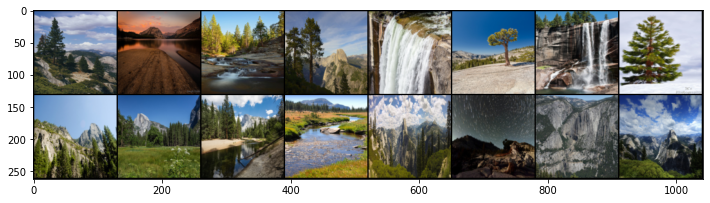

In [5]:
# sanity check show many images
X_type.show_many_images()

torch.Size([3, 128, 128])


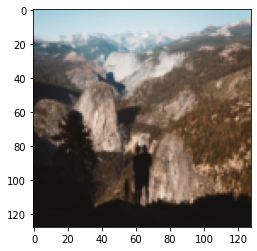

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


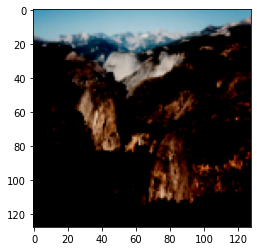

In [6]:
# sanity check scale and show image
img, _ = iter(X_type.train_loader).next()
img = img[0]
print(img.shape)
X_type.imshow(img)

scaled_image = X_type.scale(img)
X_type.imshow(scaled_image)

## Defining the models
### 1. Discrimintator

Both Discriminators DX and DY have the same properties


In [7]:
from torch import nn
import torch.nn.functional as F

class ConvSuper(nn.Module):
    '''
    This class acts as a base class with a function that is used in all children classes that are convolutional
    '''
    def _conv(self, in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
        ''' Creates a convolutional layer with optional batch normalization set to True.
            Used to downsample the image.
        '''

        layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=False)]
        
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def _deconv(self, in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
        '''Creates a transpose convolutional layer with optional batch normalization.
            Used to upsample the image.
        '''

        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, 
                                     padding, bias=False)]

        # optional batchnorm
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        
        return nn.Sequential(*layers)

class Discriminator(ConvSuper):
    def __init__(self, in_channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        
        # class attributes
        self.conv_dim = conv_dim
        self.in_channels = in_channels

        # defining the conv layers
        ### inspection #1--> depth = 3, w=128, h=128
        self.conv1 = self._conv(in_channels, conv_dim, kernel_size=4, batch_norm=False)
        ### inspection #2--> depth = 64, w=64, h=64
        self.conv2 = self._conv(conv_dim, 2*conv_dim, kernel_size=4)
        ### inspection #3--> depth = 128, w=32, h=32
        self.conv3 = self._conv(2*conv_dim, 4*conv_dim, kernel_size=4)
        ### inspection #4--> depth = 256, w=16, h=16
        self.conv4 = self._conv(4*conv_dim, 8*conv_dim, kernel_size=4)
        ### inspection #5--> depth = 512, w=8, h=8

        # The following conv layer will act as a classification layer
        self.conv5 = self._conv(8*conv_dim, 1, kernel_size=4, stride=1, batch_norm=False) 
        ### inspection #6 (Final) --> depth = 1, w=1, h=1  

    def forward(self, X):
        # encoders
        out = F.relu(self.conv1(X))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))

        # classifier
        out = F.relu(self.conv5(out))
        return out

class ResidualBlock(ConvSuper):
    '''Defines a residual block, adds input X to a convolutional layer that is applied to X
    with the same size input and output. The resblocks allow the model to learn effective transformation
    from a domian to another
    '''
    def __init__(self, conv_dim):
        # initializing super class
        super(ResidualBlock,self).__init__()

        # class attributes
        self.conv_dim = conv_dim

        # layers -- No change in dimentions
        self.conv1 = self._conv(in_channels=conv_dim, out_channels=conv_dim,
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv2 = self._conv(in_channels=conv_dim, out_channels=conv_dim,
                                kernel_size=3, stride=1, padding=1, batch_norm=True)

    def forward(self, X):
        '''
        feed forward function
        X -- input data
        '''
        out = F.relu(self.conv1(X))
        out = X + self.conv2(X)
        return X

class Generator(ConvSuper):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(Generator, self).__init__()

        # class attributes
        self.conv_dim = conv_dim
        self.n_res_blocks = n_res_blocks

        ######## encoders ########
        ### inspection #1--> depth = 3, w=128, h=128
        self.conv1 = self._conv(3,conv_dim,4)
        ### inspection #2--> depth = 64, w=64, h=64
        self.conv2 = self._conv(conv_dim, conv_dim*2, 4)
        ### inspection #3--> depth = 128, w=32, h=32
        self.conv3 = self._conv(conv_dim*2, conv_dim*4, 4)
        ### inspection #4--> depth = 256, w=16, h=16

        ######## residual blocks ########
        self.res_blocks = self.__intialize_res(conv_dim*4, n_res_blocks)

        ######## decoder ########
        ### inspection #5--> depth = 256, w=16, h=16
        self.deconv1 = self._deconv(conv_dim*4, conv_dim*2, 4)
        ### inspection #6--> depth = 128, w=32, h=32 
        self.deconv2 = self._deconv(conv_dim*2, conv_dim, 4)
        ### inspection #7--> depth = 64, w=64, h=64 
        self.deconv3 = self._deconv(conv_dim, 3, 4, batch_norm=False)  # no batch_norm
        ### inspection #8--> depth = 3, w=128, h=128

    def forward(self, X):
        '''Takes an image as an input and returns the transformed image as an output'''
        # encoders
        out = F.relu(self.conv1(X))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        # resblocks
        out = self.res_blocks(out)

        # decoders
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))

        # tanh applied at the last layer
        out = F.tanh(self.deconv3(out))

        return out

    def __intialize_res(self,conv_dim, n_blocks=1):
        layers = []
        for i in range(n_blocks):
            layers.append(ResidualBlock(conv_dim))

        return nn.Sequential(*layers)

In [8]:
# sanity check for the discriminator class
DX = Discriminator()
out = DX(img.unsqueeze(0)).squeeze().squeeze()
print(out.shape)
# delete to free memory
del DX
del out

torch.Size([7, 7])


In [9]:
# Sanity check for the generator class 
GX = Generator()
out = GX(img.unsqueeze(0)).squeeze().squeeze();
print(out.shape)
# delete to free memory
del GX
del out

torch.Size([3, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Creating Model


In [10]:
from helpers import save_samples, checkpoint
from tqdm import tqdm

class CycleGan:
    def __init__(self,g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
        self.create_CGAN_models(g_conv_dim, d_conv_dim, n_res_blocks)
        self.__print_models()

    def create_CGAN_models(self,g_conv_dim, d_conv_dim, n_res_blocks):
        '''Builds cycle gan generators and descriminator'''
        # Instintiate generators
        self.G_X2Y = Generator(g_conv_dim, n_res_blocks)
        self.G_Y2X = Generator(g_conv_dim, n_res_blocks)

        # Instantiate discriminatros
        self.D_X = Discriminator(3,d_conv_dim)
        self.D_Y = Discriminator(3,d_conv_dim)

        # config on GPU if available
        train_on_GPU = torch.cuda.is_available()
        if train_on_GPU:
            print("Configuring on GPU")
        else:
            print("Configuring on CPU")

        device = 'cuda' if train_on_GPU else 'cpu'
        self.G_X2Y.to(device)
        self.G_Y2X.to(device)
        self.D_X.to(device)
        self.D_Y.to(device)

        #return self.G_X2Y, self.G_Y2X, self.D_X, self.D_Y

    def train(self, trainloader_X, trainloader_Y, testloader_X, testloader_Y,
              g_optimizer, d_x_optimizer, d_y_optimizer, lambda_w = 10, epochs=1200, print_every=10, sample_every=100):
        '''
        trainloader_X: first domain train loader 
        trainloader_Y: second domain train loader 
        testloader_X: first domain test loader
        testloader_Y: second domain test loader
        g_optimizer: generator optimizer
        d_x_optimize: first domain discrminator optimizer 
        d_y_optimizer: second domain discriminator optimizer
        lambda_w = 10: lambda weight of the cycle consistency loss with default value 10
        epochs=1200: training epochs with default value 1200 
        print_every=10: print inspection every (default=10) epochs 
        sample_every=100: save sample every (default=100) epochs
        '''
        
        # keep track of the training losses through out time for visualization purposes
        losses = {
            'D_X':[],
            'D_Y':[],
            'G': []
        }

        # get some fixed data from both domains X and Y, for sampling purposes
        # These images are held constants throughout the training that allows the inspection of the 
        # model performance
        # take 1 image from both batches
        fixed_X = X_type.scale(next(iter(testloader_X))[0])
        fixed_Y = Y_type.scale(next(iter(testloader_Y))[0])

        # batches per epoch
        iter_X = iter(trainloader_X)
        iter_Y = iter(testloader_Y)
        batches_per_epoch = min(len(iter_X), len(iter_Y))

        for e in tqdm(range(1, epochs+1)):
            # reset iterations for each epoch
            if e % batches_per_epoch ==0:
                iter_X = iter(trainloader_X)
                iter_Y = iter(trainloader_Y)

            # get images
            X, _ = next(iter_X)
            X = X_type.scale(X)

            Y, _ = next(iter_Y)
            Y = Y_type.scale(Y)

            # check if GPU is available and move images to GPU accordingly
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            X = X.to(device)
            Y = Y.to(device)

            ##################################
            #### Train the Discriminators ####
            ##################################

            ## First: D_X real and fake loss components
            d_x_optimizer.zero_grad()

            # 1. Compute the discriminator losses on real images
            real_X = self.D_X(X)
            D_X_real_loss = self.__real_mse_loss(real_X)

            # 2. Generate fake images that look like the domain X from domain Y
            fake_X = self.G_Y2X(Y)

            # 3.  Compute the fake losses for D_X
            fake_X = self.D_X(fake_X)
            D_X_fake_loss = self.__fake_mse_loss(fake_X)

            # 4. Compute the total loss and perform backpropagation
            D_X_loss = D_X_real_loss + D_X_fake_loss
            D_X_loss.backward()
            d_x_optimizer.step()


            ## Second: D_Y, real and fake components

            d_y_optimizer.zero_grad()

            # 1. Compute the discriminator losses on real images
            real_Y = self.D_Y(Y)
            D_Y_real_loss = self.__real_mse_loss(real_Y)

            # 2. Generate fake images that look like domain Y based on images from domain X
            fake_Y = self.G_X2Y(X)

            # 3. Compute fake loss for D_Y
            fake_Y = self.D_Y(fake_Y)
            D_Y_fake_loss = self.__fake_mse_loss(fake_Y)

            # 4. Compute total losses and perform backpropagation
            D_Y_loss = D_Y_real_loss + D_Y_fake_loss
            D_Y_loss.backward()
            d_y_optimizer.step()

            ##############################
            #### Train the Generators ####
            ##############################

            g_optimizer.zero_grad()

            #### First generate fake X images and reconstructed Y ###

            # 1. generate fake images that look like domain X
            fake_X = self.G_Y2X(Y)

            # 2. Compute the loss based on domain X
            out_X = self.D_X(fake_X)
            g_Y2X_loss = self.__real_mse_loss(out_X)

            # 3. Compute the reconstructed Y
            recon_Y = self.G_X2Y(fake_X)

            # 4. Compute the cycle consistency loss
            recon_Y_loss = self.__cycle_consistency_loss(Y, recon_Y, lambda_w)

            #### Second generate fake Y images and reconstructed X ###

             # 1. generate fake images that look like domain X
            fake_Y = self.G_X2Y(X)

            # 2. Compute the loss based on domain X
            out_Y = self.D_Y(fake_Y)
            g_X2Y_loss = self.__real_mse_loss(out_Y)

            # 3. Compute the reconstructed Y
            recon_X = self.G_Y2X(fake_Y)

            # 4. Compute the cycle consistency loss
            recon_X_loss = self.__cycle_consistency_loss(X, recon_X, lambda_w = lambda_w)

            ## addup all generator losses and perform backpropagation
            g_total_loss = g_X2Y_loss + g_Y2X_loss + recon_X_loss + recon_Y_loss
            g_total_loss.backward()
            g_optimizer.step()

            # Print the log info
            if e % print_every == 0:
                # append real and fake discriminator losses and the generator loss
                losses['D_X'].append(D_X_loss.item())
                losses['D_Y'].append(D_Y_loss.item())
                losses['G'].append(g_total_loss.item())
                #losses.append((D_X_loss.item(), D_Y_loss.item(), g_total_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                        e, epochs, D_X_loss.item(), D_Y_loss.item(), g_total_loss.item()))

            # Save the generated samples
            if e % sample_every == 0:
                self.G_Y2X.eval() # set generators to eval mode for sample generation
                self.G_X2Y.eval()
                save_samples(e, fixed_Y, fixed_X, self.G_Y2X, self.G_X2Y, batch_size=16)

                # return to training mode
                self.G_Y2X.train()
                self.G_X2Y.train()

        return losses

    def __real_mse_loss(self, D_out):
        return torch.mean((D_out-1)**2)

    def __fake_mse_loss(self, D_out):
        return torch.mean(D_out**2)

    def __cycle_consistency_loss(self, real_im, reconstructed_im, lambda_w):
        # calculate reconstruction loss
        recon_loss = torch.mean(torch.abs(real_im - reconstructed_im))

        # return weighted loss
        return lambda_w*recon_loss    

    def __print_models(self):
        """Prints model information for the generators and discriminators.
        """
        print("                     G_X2Y                    ")
        print("-----------------------------------------------")
        print(self.G_X2Y)
        print()

        print("                     G_Y2X                    ")
        print("-----------------------------------------------")
        print(self.G_Y2X)
        print()

        print("                      D_X                      ")
        print("-----------------------------------------------")
        print(self.D_X)
        print()

        print("                      D_Y                      ")
        print("-----------------------------------------------")
        print(self.D_Y)
        print()

# Creating Models
cgan_model = CycleGan()

Configuring on GPU
                     G_X2Y                    
-----------------------------------------------
Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [11]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(cgan_model.G_X2Y.parameters()) + list(cgan_model.G_Y2X.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(cgan_model.D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(cgan_model.D_Y.parameters(), lr, [beta1, beta2])

In [12]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = cgan_model.train(train_loader_X, train_loader_Y, 
                          test_loader_X, test_loader_Y, g_optimizer=g_optimizer, d_x_optimizer=d_x_optimizer,
                          d_y_optimizer=d_y_optimizer,lambda_w = 10, epochs=n_epochs, print_every=100, sample_every=100)

  2%|▏         | 99/4000 [05:32<1:51:04,  1.71s/it]

Epoch [  100/ 4000] | d_X_loss: 0.4971 | d_Y_loss: 0.5364 | g_total_loss: 4.1819


Saved samples_cyclegan/sample-000100-X-Y.png


  2%|▎         | 100/4000 [05:35<2:02:45,  1.89s/it]

Saved samples_cyclegan/sample-000100-Y-X.png


  5%|▍         | 199/4000 [07:00<31:22,  2.02it/s]

Epoch [  200/ 4000] | d_X_loss: 0.4390 | d_Y_loss: 0.4866 | g_total_loss: 3.9752


Saved samples_cyclegan/sample-000200-X-Y.png


  5%|▌         | 200/4000 [07:02<50:18,  1.26it/s]

Saved samples_cyclegan/sample-000200-Y-X.png


  7%|▋         | 299/4000 [07:38<17:55,  3.44it/s]

Epoch [  300/ 4000] | d_X_loss: 0.5763 | d_Y_loss: 0.4182 | g_total_loss: 3.8054


Saved samples_cyclegan/sample-000300-X-Y.png


  8%|▊         | 300/4000 [07:39<39:38,  1.56it/s]

Saved samples_cyclegan/sample-000300-Y-X.png


 10%|▉         | 399/4000 [08:07<15:15,  3.94it/s]

Epoch [  400/ 4000] | d_X_loss: 0.4292 | d_Y_loss: 0.4628 | g_total_loss: 3.2417


Saved samples_cyclegan/sample-000400-X-Y.png


 10%|█         | 400/4000 [08:09<37:57,  1.58it/s]

Saved samples_cyclegan/sample-000400-Y-X.png


 12%|█▏        | 499/4000 [08:34<14:55,  3.91it/s]

Epoch [  500/ 4000] | d_X_loss: 0.4595 | d_Y_loss: 0.5396 | g_total_loss: 3.9933


Saved samples_cyclegan/sample-000500-X-Y.png


 12%|█▎        | 500/4000 [08:35<35:22,  1.65it/s]

Saved samples_cyclegan/sample-000500-Y-X.png


 15%|█▍        | 599/4000 [09:01<14:31,  3.90it/s]

Epoch [  600/ 4000] | d_X_loss: 0.3221 | d_Y_loss: 0.3544 | g_total_loss: 3.5405


Saved samples_cyclegan/sample-000600-X-Y.png


 15%|█▌        | 600/4000 [09:03<36:44,  1.54it/s]

Saved samples_cyclegan/sample-000600-Y-X.png


 17%|█▋        | 699/4000 [09:28<14:10,  3.88it/s]

Epoch [  700/ 4000] | d_X_loss: 0.4290 | d_Y_loss: 0.4957 | g_total_loss: 3.3518


Saved samples_cyclegan/sample-000700-X-Y.png


 18%|█▊        | 700/4000 [09:30<34:01,  1.62it/s]

Saved samples_cyclegan/sample-000700-Y-X.png


 20%|█▉        | 799/4000 [09:55<13:48,  3.86it/s]

Epoch [  800/ 4000] | d_X_loss: 0.3698 | d_Y_loss: 0.1560 | g_total_loss: 3.7453


Saved samples_cyclegan/sample-000800-X-Y.png


 20%|██        | 800/4000 [09:57<33:08,  1.61it/s]

Saved samples_cyclegan/sample-000800-Y-X.png


 22%|██▏       | 899/4000 [10:22<13:15,  3.90it/s]

Epoch [  900/ 4000] | d_X_loss: 1.0000 | d_Y_loss: 0.2101 | g_total_loss: 4.1889


Saved samples_cyclegan/sample-000900-X-Y.png


 22%|██▎       | 900/4000 [10:24<32:53,  1.57it/s]

Saved samples_cyclegan/sample-000900-Y-X.png


 25%|██▍       | 999/4000 [10:49<13:00,  3.85it/s]

Epoch [ 1000/ 4000] | d_X_loss: 0.5269 | d_Y_loss: 0.3075 | g_total_loss: 3.4095


Saved samples_cyclegan/sample-001000-X-Y.png


 25%|██▌       | 1000/4000 [10:51<31:48,  1.57it/s]

Saved samples_cyclegan/sample-001000-Y-X.png


 27%|██▋       | 1099/4000 [11:17<12:34,  3.85it/s]

Epoch [ 1100/ 4000] | d_X_loss: 0.2832 | d_Y_loss: 0.1870 | g_total_loss: 3.6869


Saved samples_cyclegan/sample-001100-X-Y.png


 28%|██▊       | 1100/4000 [11:18<25:53,  1.87it/s]

Saved samples_cyclegan/sample-001100-Y-X.png


 30%|██▉       | 1199/4000 [11:44<12:06,  3.86it/s]

Epoch [ 1200/ 4000] | d_X_loss: 0.4055 | d_Y_loss: 0.1847 | g_total_loss: 4.2012


Saved samples_cyclegan/sample-001200-X-Y.png


 30%|███       | 1200/4000 [11:45<29:49,  1.56it/s]

Saved samples_cyclegan/sample-001200-Y-X.png


 32%|███▏      | 1299/4000 [12:11<11:38,  3.87it/s]

Epoch [ 1300/ 4000] | d_X_loss: 0.2082 | d_Y_loss: 0.6595 | g_total_loss: 3.5393


Saved samples_cyclegan/sample-001300-X-Y.png


 32%|███▎      | 1300/4000 [12:12<30:04,  1.50it/s]

Saved samples_cyclegan/sample-001300-Y-X.png


 35%|███▍      | 1399/4000 [12:38<11:14,  3.86it/s]

Epoch [ 1400/ 4000] | d_X_loss: 0.2286 | d_Y_loss: 0.1810 | g_total_loss: 3.3304


Saved samples_cyclegan/sample-001400-X-Y.png


 35%|███▌      | 1400/4000 [12:39<23:49,  1.82it/s]

Saved samples_cyclegan/sample-001400-Y-X.png


 37%|███▋      | 1499/4000 [13:05<10:46,  3.87it/s]

Epoch [ 1500/ 4000] | d_X_loss: 0.1922 | d_Y_loss: 0.0367 | g_total_loss: 4.5777


Saved samples_cyclegan/sample-001500-X-Y.png


 38%|███▊      | 1500/4000 [13:07<26:43,  1.56it/s]

Saved samples_cyclegan/sample-001500-Y-X.png


 40%|███▉      | 1599/4000 [13:32<10:19,  3.88it/s]

Epoch [ 1600/ 4000] | d_X_loss: 0.0359 | d_Y_loss: 0.0094 | g_total_loss: 4.0015


Saved samples_cyclegan/sample-001600-X-Y.png


 40%|████      | 1600/4000 [13:34<25:17,  1.58it/s]

Saved samples_cyclegan/sample-001600-Y-X.png


 42%|████▏     | 1699/4000 [13:59<09:50,  3.90it/s]

Epoch [ 1700/ 4000] | d_X_loss: 0.0677 | d_Y_loss: 0.0126 | g_total_loss: 3.7243


Saved samples_cyclegan/sample-001700-X-Y.png


 42%|████▎     | 1700/4000 [14:01<24:08,  1.59it/s]

Saved samples_cyclegan/sample-001700-Y-X.png


 45%|████▍     | 1799/4000 [14:26<09:21,  3.92it/s]

Epoch [ 1800/ 4000] | d_X_loss: 0.0074 | d_Y_loss: 0.0413 | g_total_loss: 4.3573


Saved samples_cyclegan/sample-001800-X-Y.png


 45%|████▌     | 1800/4000 [14:28<23:32,  1.56it/s]

Saved samples_cyclegan/sample-001800-Y-X.png


 47%|████▋     | 1899/4000 [14:53<09:00,  3.89it/s]

Epoch [ 1900/ 4000] | d_X_loss: 0.0203 | d_Y_loss: 0.0055 | g_total_loss: 4.2073


Saved samples_cyclegan/sample-001900-X-Y.png


 48%|████▊     | 1900/4000 [14:54<23:53,  1.47it/s]

Saved samples_cyclegan/sample-001900-Y-X.png


 50%|████▉     | 1999/4000 [15:20<08:26,  3.95it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.0294 | d_Y_loss: 0.0076 | g_total_loss: 4.1601
Saved samples_cyclegan/sample-002000-X-Y.png


 50%|█████     | 2000/4000 [15:21<17:50,  1.87it/s]

Saved samples_cyclegan/sample-002000-Y-X.png


 52%|█████▏    | 2099/4000 [15:46<08:08,  3.90it/s]

Epoch [ 2100/ 4000] | d_X_loss: 0.0044 | d_Y_loss: 0.0055 | g_total_loss: 3.7839


Saved samples_cyclegan/sample-002100-X-Y.png


 52%|█████▎    | 2100/4000 [15:48<20:19,  1.56it/s]

Saved samples_cyclegan/sample-002100-Y-X.png


 55%|█████▍    | 2199/4000 [16:13<07:38,  3.92it/s]

Epoch [ 2200/ 4000] | d_X_loss: 0.0453 | d_Y_loss: 0.0081 | g_total_loss: 3.4692


Saved samples_cyclegan/sample-002200-X-Y.png


 55%|█████▌    | 2200/4000 [16:14<19:23,  1.55it/s]

Saved samples_cyclegan/sample-002200-Y-X.png


 57%|█████▋    | 2299/4000 [16:39<07:20,  3.86it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.0473 | d_Y_loss: 0.0492 | g_total_loss: 3.6430
Saved samples_cyclegan/sample-002300-X-Y.png


 57%|█████▊    | 2300/4000 [16:41<15:28,  1.83it/s]

Saved samples_cyclegan/sample-002300-Y-X.png


 60%|█████▉    | 2399/4000 [17:06<06:44,  3.96it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.0042 | d_Y_loss: 0.0102 | g_total_loss: 3.5255


Saved samples_cyclegan/sample-002400-X-Y.png


 60%|██████    | 2400/4000 [17:07<11:49,  2.26it/s]

Saved samples_cyclegan/sample-002400-Y-X.png


 62%|██████▏   | 2499/4000 [17:32<06:19,  3.96it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.0096 | d_Y_loss: 0.0094 | g_total_loss: 3.5724


Saved samples_cyclegan/sample-002500-X-Y.png


 62%|██████▎   | 2500/4000 [17:33<10:58,  2.28it/s]

Saved samples_cyclegan/sample-002500-Y-X.png


 65%|██████▍   | 2599/4000 [17:58<05:51,  3.99it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.0102 | d_Y_loss: 0.0325 | g_total_loss: 3.9139


Saved samples_cyclegan/sample-002600-X-Y.png


 65%|██████▌   | 2600/4000 [17:59<10:17,  2.27it/s]

Saved samples_cyclegan/sample-002600-Y-X.png


 67%|██████▋   | 2699/4000 [18:24<05:32,  3.92it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.5914 | d_Y_loss: 0.0298 | g_total_loss: 3.4092


Saved samples_cyclegan/sample-002700-X-Y.png


 68%|██████▊   | 2700/4000 [18:25<09:44,  2.22it/s]

Saved samples_cyclegan/sample-002700-Y-X.png


 70%|██████▉   | 2799/4000 [18:50<05:00,  3.99it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.0051 | d_Y_loss: 0.0044 | g_total_loss: 4.2876


Saved samples_cyclegan/sample-002800-X-Y.png


 70%|███████   | 2800/4000 [18:51<08:52,  2.25it/s]

Saved samples_cyclegan/sample-002800-Y-X.png


 72%|███████▏  | 2899/4000 [19:16<04:35,  4.00it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.0051 | d_Y_loss: 0.0034 | g_total_loss: 3.6277


Saved samples_cyclegan/sample-002900-X-Y.png


 72%|███████▎  | 2900/4000 [19:17<07:59,  2.29it/s]

Saved samples_cyclegan/sample-002900-Y-X.png


 75%|███████▍  | 2999/4000 [19:42<04:14,  3.94it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.0057 | d_Y_loss: 0.4757 | g_total_loss: 3.4144


Saved samples_cyclegan/sample-003000-X-Y.png


 75%|███████▌  | 3000/4000 [19:43<07:29,  2.22it/s]

Saved samples_cyclegan/sample-003000-Y-X.png


 77%|███████▋  | 3099/4000 [20:08<03:46,  3.97it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.0020 | d_Y_loss: 0.0061 | g_total_loss: 3.7569


Saved samples_cyclegan/sample-003100-X-Y.png


 78%|███████▊  | 3100/4000 [20:09<06:38,  2.26it/s]

Saved samples_cyclegan/sample-003100-Y-X.png


 80%|███████▉  | 3199/4000 [20:34<03:21,  3.97it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.0036 | d_Y_loss: 0.0026 | g_total_loss: 3.3067


Saved samples_cyclegan/sample-003200-X-Y.png


 80%|████████  | 3200/4000 [20:35<05:54,  2.26it/s]

Saved samples_cyclegan/sample-003200-Y-X.png


 82%|████████▏ | 3299/4000 [21:00<02:58,  3.92it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.0069 | d_Y_loss: 0.0069 | g_total_loss: 3.6982


Saved samples_cyclegan/sample-003300-X-Y.png


 82%|████████▎ | 3300/4000 [21:01<05:10,  2.25it/s]

Saved samples_cyclegan/sample-003300-Y-X.png


 85%|████████▍ | 3399/4000 [21:26<02:32,  3.93it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.0051 | d_Y_loss: 0.0027 | g_total_loss: 3.6498


Saved samples_cyclegan/sample-003400-X-Y.png


 85%|████████▌ | 3400/4000 [21:27<04:21,  2.29it/s]

Saved samples_cyclegan/sample-003400-Y-X.png


 87%|████████▋ | 3499/4000 [21:52<02:05,  3.98it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.0053 | d_Y_loss: 0.0025 | g_total_loss: 3.6344


Saved samples_cyclegan/sample-003500-X-Y.png


 88%|████████▊ | 3500/4000 [21:53<03:37,  2.30it/s]

Saved samples_cyclegan/sample-003500-Y-X.png


 90%|████████▉ | 3599/4000 [22:18<01:42,  3.91it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.3631 | d_Y_loss: 0.0025 | g_total_loss: 3.6983


 90%|█████████ | 3600/4000 [22:19<02:53,  2.31it/s]

Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png


 92%|█████████▏| 3699/4000 [22:44<01:16,  3.93it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.0060 | d_Y_loss: 0.0046 | g_total_loss: 3.5712


Saved samples_cyclegan/sample-003700-X-Y.png


 92%|█████████▎| 3700/4000 [22:45<02:14,  2.23it/s]

Saved samples_cyclegan/sample-003700-Y-X.png


 95%|█████████▍| 3799/4000 [23:10<00:50,  3.96it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.0015 | g_total_loss: 3.4518


Saved samples_cyclegan/sample-003800-X-Y.png


 95%|█████████▌| 3800/4000 [23:11<01:29,  2.23it/s]

Saved samples_cyclegan/sample-003800-Y-X.png


 97%|█████████▋| 3899/4000 [23:36<00:25,  3.98it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.0044 | d_Y_loss: 0.0027 | g_total_loss: 3.5239


Saved samples_cyclegan/sample-003900-X-Y.png


 98%|█████████▊| 3900/4000 [23:37<00:44,  2.26it/s]

Saved samples_cyclegan/sample-003900-Y-X.png


100%|█████████▉| 3999/4000 [24:02<00:00,  3.97it/s]WARNING:root:Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.0031 | d_Y_loss: 0.0022 | g_total_loss: 3.3868


Saved samples_cyclegan/sample-004000-X-Y.png


100%|██████████| 4000/4000 [24:03<00:00,  2.77it/s]

Saved samples_cyclegan/sample-004000-Y-X.png


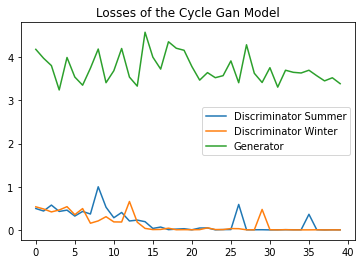

In [68]:
%matplotlib inline

def visualize_losses(losses):
    '''
    losses ob of all the losses in the system.
    losses keys[
        'D_X'
        'D_Y'
        'G'
    ]
    '''
    plt.title("Losses of the Cycle Gan Model")
    plt.plot(losses['D_X'],label='Discriminator Summer')
    plt.plot(losses['D_Y'], label='Discriminator Winter')
    plt.plot(losses['G'], label = 'Generator')
    plt.legend()
    plt.show();

visualize_losses(losses)

In [69]:
 def test_model(model, batch_size=16):
    g_loss = 0
    dx_loss = 0
    dy_loss = 0
    train_on_GPU = torch.cuda.is_available()
    if train_on_GPU:
        print("Configuring on GPU")
    else:
        print("Configuring on CPU")

    device = 'cuda' if train_on_GPU else 'cpu'
    model.D_X.eval()
    model.D_Y.eval()
    model.G_X2Y.eval()
    model.G_Y2X.eval()   
    itr = 0
    with torch.no_grad(): 
        for x, y in tqdm(zip(test_loader_X, test_loader_Y)):
            
            x,_ = x
            y,_ = y
            x = x.to(device)
            y = y.to(device)
            x = X_type.scale(x)
            y = Y_type.scale(y)
            #1. calculate the real error
            real_ims_res_x = model.D_X(x)
            real_ims_err_x = torch.mean((real_ims_res_x-1)**2)
            real_ims_res_y = model.D_Y(y)
            real_ims_err_y = torch.mean((real_ims_res_y-1)**2)

            #2. generate fake images from the batch
            fake_ims_x = model.G_Y2X(y)
            fake_ims_y = model.G_X2Y(x)
            fake_ims_err_x = torch.mean(model.D_X(fake_ims_y**2))
            fake_ims_err_y = torch.mean(model.D_Y(fake_ims_x**2))
            
            #3. calculate the Discriminator error
            d_error_x = fake_ims_err_x + real_ims_err_x
            d_error_y = fake_ims_err_x + real_ims_err_y
            
            #4. calculate the real error with these fakeimages
            recon_im_y = model.G_X2Y(fake_ims_x)
            recon_im_x = model.G_Y2X(fake_ims_y)
            recon_im_y_logits = model.D_Y(recon_im_y)
            recon_im_x_logits = model.D_X(recon_im_x)
            
            #5. calculate real adverserial error on the generated image
            adv_real_error_y =  torch.mean((model.D_Y(fake_ims_x)-1)**2)
            adv_real_error_x =  torch.mean((model.D_Y(fake_ims_y)-1)**2)
            
            #6. calculate the error of the generated image in discriminator
            recon_im_x_err = torch.mean((recon_im_x_logits-1)**2)
            recon_im_y_err = torch.mean((recon_im_y_logits-1)**2)
            
            #7. calculate cycle loss and add losses to the current loss
            dx_loss+= d_error_x/batch_size
            dy_loss+= d_error_y/batch_size
            ccl_x = torch.mean(torch.abs(x - recon_im_x))
            ccl_y = torch.mean(torch.abs(y - recon_im_y))
            g_loss += (ccl_x + ccl_y + recon_im_x_err + recon_im_y_err)/batch_size

            # save test samples
            save_samples(itr, y, x, model.G_Y2X, model.G_X2Y, batch_size=16, sample_dir='test_samples')

            # increment iteration
            itr+=1

            return dx_loss.item(), dy_loss.item(), g_loss.item()


loss_dx, loss_dy, loss_g = test_model(cgan_model);

print()
print()
print("\t\t\t Testing Loss")
print()
print("Testing loss Discriminator X\t:\t", loss_dx)
print("Testing loss Discriminator Y\t:\t", loss_dy)
print("Testing loss Generators\t\t:\t", loss_g)

0it [00:00, ?it/s]

Configuring on GPU


Saved test_samples/sample-000000-X-Y.png


0it [00:00, ?it/s]

Saved test_samples/sample-000000-Y-X.png


			 Testing Loss

Testing loss Discriminator X	:	 0.03791981190443039
Testing loss Discriminator Y	:	 0.04710119217634201
Testing loss Generators		:	 0.15848776698112488




## Drawbacks 
1. Up-sampling with low resolution reduces the the quality of the image. May consider some other techniques (mentioned in the the Consideratons section).

2. There are some images that are wrongly generated, seems like the model treats any kind of wood as a plant and hence, generates the green leaves in winter to summer generation, and vice versa.

## Considerations

1. Re-implementing the model with conditional GAN may lead to higher resolution
2. Better tuning may lead to better results

#### Note that: Training samples are found in 'samples_cyclegan' folder and the test results are found in the 'test_samples' directory.